In [1]:
from __future__ import print_function
%matplotlib inline

import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cv2
import numpy as np
import math

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

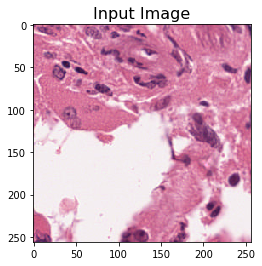

In [2]:
inputImageFile =('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


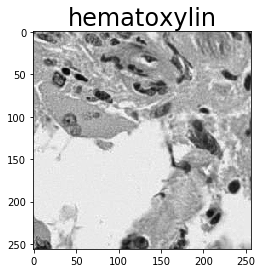

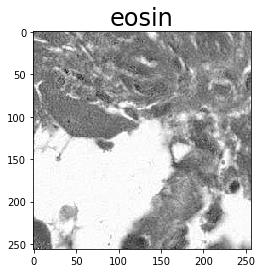

In [3]:
# create stain to color map using HistomicsTK
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

# Display results
for i in range(0, 2):
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

In [4]:
print(imDeconvolved.Stains[0,0,0])
print(imDeconvolved.Stains[0,1,0])
print(imDeconvolved.Stains[1,0,0])
print(np.average(imDeconvolved.Stains[0,0,0]))
print(np.average(imDeconvolved.Stains[0,1,0]))
print(np.average(imDeconvolved.Stains[1,0,0]))

131
139
77
131.0
139.0
77.0


In [5]:
print(imDeconvolved.Stains[0,0,1])
print(imDeconvolved.Stains[0,1,1])
print(imDeconvolved.Stains[1,0,1])
print(np.average(imDeconvolved.Stains[0,0,1]))
print(np.average(imDeconvolved.Stains[0,1,1]))
print(np.average(imDeconvolved.Stains[1,0,1]))

138
131
158
138.0
131.0
158.0


In [6]:
print(imDeconvolved.Stains[100,160,0])
print(imDeconvolved.Stains[100,160,1])
print(imInput[100,160,0])
print(imInput[100,160,1])
print(imInput[100,160,2])
print(imDeconvolved.Stains[100,160,:])

141
146
186
100
149
[141 146 184]


In [7]:
# Calculating Purple, Pink, White Pixels' - x,y co-ordinates
# Purple pixel:Cell Nuclie Material, 
# Pink Pixel:Stroma, Stomal cells’ cytoplasams, mucin-poor epithelial cells’s cytoplasms
# White pixels - Lumina, mucin-rich epithelial cells’s cytoplasms
def pixel_obj_gen(img_shape,imDecon_stains):  
    # Calculating hematoxylin average
    h_avg = np.average(imDecon_stains.Stains[:, :, 0])

    # Calculating Eosin average
    e_avg = np.average(imDecon_stains.Stains[:, :, 1])
    
    purple_pixel = []
    pink_pixel = []
    white_pixel = []
    purple_x = []
    purple_y = []
    pink_x = []
    pink_y = []
    white_x = []
    white_y = []
    for i in range(0,img_shape[0]):
          for j in range(0,img_shape[1]):
              h_p = imDecon_stains.Stains[i,j,0]
              e_p = imDecon_stains.Stains[i,j,1]
              if h_p <= h_avg: purple_pixel.append([i,j,h_p,e_p]),purple_x.append(i),purple_y.append(j)
              if (h_p > h_avg and e_p <= e_avg): pink_pixel.append([i,j,h_p,e_p]),pink_x.append(i),pink_y.append(j)
              if (h_p > h_avg and e_p > e_avg): white_pixel.append([i,j,h_p,e_p]),white_x.append(i),white_y.append(j)
    return purple_pixel, purple_x, purple_y, pink_pixel, pink_x, pink_y, white_pixel, white_x, white_y

In [13]:
h_avg = np.average(imDecon_stains.Stains[:, :, 0])
e_avg = np.average(imDecon_stains.Stains[:, :, 1])
print(h_avg, e_avg)
print(purple_pixel[0], pink_pixel[0], white_pixel[0])
print(purple_x[0], purple_y[0])
print(pink_x[0], pink_y[0])
print(white_x[0], white_y[0])
print(imDecon_stains.Stains[0,0,0], imDecon_stains.Stains[0,0,0])
print(imDecon_stains.Stains[0,5,0], imDecon_stains.Stains[0,5,1])
print(imDecon_stains.Stains[0,37,0], imDecon_stains.Stains[0,37,1])

184.5366973876953 189.68443298339844
[0, 0, 131, 138] [0, 5, 187, 139] [0, 37, 203, 204]
0 0
0 5
0 37
131 131
187 139
203 204


In [8]:
def circle_fit(x_coords,y_coords,pixel_len):
    # Pre-processing for Circle Fitting Algorithm for Histological objects
    x1 = np.array(x_coords) # Array of x-coordinates 
    y1 = np.array(y_coords) # Array of y-coordinates

    # Apply transformation on x,y co-ordinates
    x2 = x1.reshape(1, pixel_len)
    y2 = y1.reshape(1, pixel_len)

    # Mean value of x co-ordinates
    sum_x=0
    for i in range(pixel_len):
        sum_x=sum_x+x2[0,i]
    x_mean=sum_x/(pixel_len -1)

    # Mean value of y co-ordinates
    sum_y=0
    for i in range(pixel_len):
        sum_y=sum_y+y2[0,i]
    y_mean=sum_y/(pixel_len - 1)
    
    # Circle Fitting Algorithm using linear algebra    
    u=[]
    v=[]
    Suv  = 0
    Suu  = 0
    Svv  = 0
    Suuv = 0
    Suvv = 0
    Suuu = 0
    Svvv = 0

    # calculation of the reduced coordinates
    for i in range(pixel_len):
            u.append((x2[0,i] - x_mean))
            v.append((y2[0,i] - y_mean))

    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    for i in range(pixel_len):
        Suv  = Suv + (u[i]*v[i])
        Suu  = Suu+(u[i]*u[i])
        Svv  = Svv+(v[i]*v[i])
        Suuv = Suuv+(u[i]*u[i]*v[i])
        Suvv = Suvv+(u[i]* v[i]**2)
        Suuu = Suuu+(u[i]**3)
        Svvv = Svvv+(v[i]**3)

    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)

    xc_1 = x_mean + uc
    yc_1 = y_mean + vc

    # Calcuating Radius
    alpha = uc**2 + vc**2 +((Suu+Svv)/(pixel_len - 1))
    radius=math.sqrt(alpha)
    
    return xc_1, yc_1,radius 

In [9]:
img_shape = imInput.shape
imDecon_stains = imDeconvolved
purple_pixel, purple_x, purple_y, pink_pixel, pink_x, pink_y, white_pixel, white_x, white_y = pixel_obj_gen(img_shape,imDecon_stains)

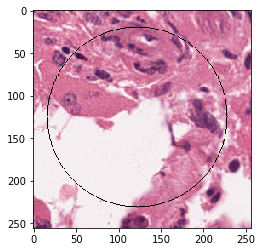

In [10]:
# Purple pixel Circle (Largest Object Circle) generation
purple_pixel_len=len(purple_pixel)
purple_xc_1, purple_yc_1, purple_radius = circle_fit(purple_x, purple_y, purple_pixel_len)

cv2.circle(imInput,(int(round(purple_xc_1)),int(round(purple_yc_1))),int(round(purple_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/purple_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/purple_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
# Purple objects generation
# Step1: Purple Pixels identification within Largest Object Circle and generation of those pixel coordinates
# Step2: Draw largest object circles for each identified pixels

purple_pixel_len=len(purple_pixel)
purple_cir_inside = []
purple_cir_outside = []
purple_cir_oncircle = []

# Step1: Purple Pixels identification within Largest Object Circle and generation of those pixel coordinates
for i in range (0,purple_pixel_len):
    z = ((purple_x[i] - purple_xc_1)**2 - (purple_y[i] - purple_yc_1)**2) - purple_radius**2  
    if z<0: purple_cir_inside.append([purple_x[i],purple_y[i]])
    if z>0: purple_cir_outside.append([purple_x[i],purple_y[i]])
    if z==0: purple_cir_oncircle.append([purple_x[i],purple_y[i]])

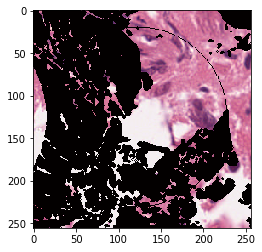

In [12]:
# Step2: Draw largest object circles for each identified pixels - Inside Circle
purple_pixels_ic_len = len(purple_cir_inside)

purple_xc_ic_1 = [] # Inside Circle Coordinates
purple_yc_ic_1 = [] # Inside Circle Coordinates
purple_radius_ic = [] # Inside circle Radius

for i in range(0, purple_pixels_ic_len-1):
    cv2.circle(imInput,(purple_cir_inside[i][0],purple_cir_inside[i][1]),1, 3)    
    cv2.imwrite('/home/raj/Downloads/purple_obj_ic_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
                cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))

im = cv2.imread('/home/raj/Downloads/purple_obj_ic_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()  

In [14]:
# Step2: Draw largest object circles for each identified pixels - On Circle
purple_pixels_oc_len = len(purple_cir_oncircle)
purple_xc_oc_1 = [] # On Circle Coordinates
purple_yc_oc_1 = [] # On Circle Coordinates
purple_radius_oc = [] # On circle Radius

for i in range(0, purple_pixels_oc_len-1):
    cv2.circle(imInput,(purple_cir_oncircle[i][0],purple_cir_oncircle[i][1]),1, 3)    
    cv2.imwrite('/home/raj/Downloads/purple_obj_oc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
                cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))

im = cv2.imread('/home/raj/Downloads/purple_obj_oc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()  

error: OpenCV(3.4.3) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


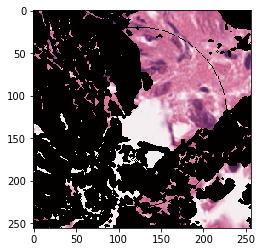

In [15]:
# Step2: Draw largest object circles for each identified pixels - Outside Circle
purple_pixels_ouc_len = len(purple_cir_outside)

purple_xc_ouc_1 = [] # Outside Circle Coordinates
purple_yc_ouc_1 = [] # Outside Circle Coordinates
purple_radius_ouc = [] # Outside circle Radius

for i in range(0, purple_pixels_ouc_len-1):
    cv2.circle(imInput,(purple_cir_outside[i][0],purple_cir_outside[i][1]),1, 3)    
    cv2.imwrite('/home/raj/Downloads/purple_obj_ouc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
                cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))

im = cv2.imread('/home/raj/Downloads/purple_obj_ouc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()  

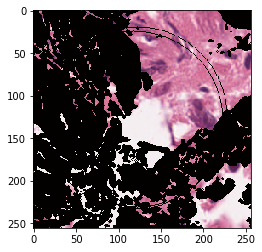

In [16]:
# Pink pixel Circle generation
pink_pixel_len=len(pink_pixel)
pink_xc_1, pink_yc_1, pink_radius = circle_fit(pink_x, pink_y, pink_pixel_len)

cv2.circle(imInput,(int(round(pink_xc_1)),int(round(pink_yc_1))),int(round(pink_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/pink_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/pink_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
# Pink objects generation
# Step1: Pink Pixels identification within Largest Object Circle and generation of those pixel coordinates
# Step2: Draw largest object circles for each identified pixels

pink_pixel_len=len(pink_pixel)
pink_cir_inside = []
pink_cir_outside = []
pink_cir_oncircle = []

# Step1: Pink Pixels identification within Largest Object Circle and generation of those pixel coordinates
for i in range (0,pink_pixel_len):
    z = ((pink_x[i] - pink_xc_1)**2 - (pink_y[i] - pink_yc_1)**2) - pink_radius**2  
    if z<0: pink_cir_inside.append([pink_x[i],pink_y[i]])
    if z>0: pink_cir_outside.append([pink_x[i],pink_y[i]])
    if z==0: pink_cir_oncircle.append([pink_x[i],pink_y[i]])

In [18]:
len(pink_cir_inside),len(pink_cir_outside), len(pink_cir_oncircle)

(5760, 337, 0)

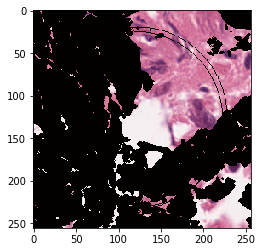

In [19]:
# Step2: Draw largest object circles for each identified pixels - Inside Circle Pink
pink_pixels_ic_len = len(pink_cir_inside)

pink_xc_ic_1 = [] # Inside Circle Coordinates
pink_yc_ic_1 = [] # Inside Circle Coordinates
pink_radius_ic = [] # Inside circle Radius

for i in range(0, pink_pixels_ic_len-1):
    cv2.circle(imInput,(pink_cir_inside[i][0],pink_cir_inside[i][1]),1, 3)    
    cv2.imwrite('/home/raj/Downloads/pink_obj_ic_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
                cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))

im = cv2.imread('/home/raj/Downloads/pink_obj_ic_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()  

In [20]:
# Step2: Draw largest object circles for each identified pixels - On Circle
pink_pixels_oc_len = len(pink_cir_oncircle)
pink_xc_oc_1 = [] # On Circle Coordinates
pink_yc_oc_1 = [] # On Circle Coordinates
pink_radius_oc = [] # On circle Radius

for i in range(0, pink_pixels_oc_len-1):
    cv2.circle(imInput,(pink_cir_oncircle[i][0],pink_cir_oncircle[i][1]),1, 3)    
    cv2.imwrite('/home/raj/Downloads/pink_obj_oc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
                cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))

im = cv2.imread('/home/raj/Downloads/pink_obj_oc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()  

error: OpenCV(3.4.3) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


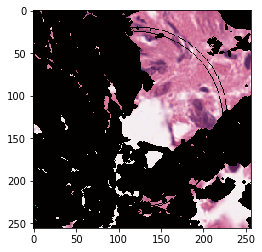

In [21]:
# Step2: Draw largest object circles for each identified pixels - Outside Circle
pink_pixels_ouc_len = len(pink_cir_outside)

pink_xc_ouc_1 = [] # Outside Circle Coordinates
pink_yc_ouc_1 = [] # Outside Circle Coordinates
pink_radius_ouc = [] # Outside circle Radius

for i in range(0, pink_pixels_ouc_len-1):
    cv2.circle(imInput,(pink_cir_outside[i][0],pink_cir_outside[i][1]),1, 3)    
    cv2.imwrite('/home/raj/Downloads/pink_obj_ouc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
                cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))

im = cv2.imread('/home/raj/Downloads/pink_obj_ouc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show() 

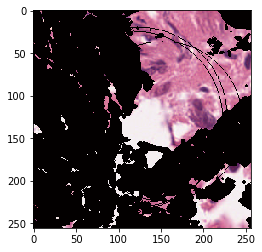

In [22]:
# White pixel Circle generation
white_pixel_len=len(white_pixel)
white_xc_1, white_yc_1, white_radius = circle_fit(white_x, white_y, white_pixel_len)

cv2.circle(imInput,(int(round(white_xc_1)),int(round(white_yc_1))),int(round(white_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/white_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/white_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
# White objects generation
# Step1: Pink Pixels identification within Largest Object Circle and generation of those pixel coordinates
# Step2: Draw largest object circles for each identified pixels

white_pixel_len=len(white_pixel)
white_cir_inside = []
white_cir_outside = []
white_cir_oncircle = []

# Step1: White Pixels identification within Largest Object Circle and generation of those pixel coordinates
for i in range (0,white_pixel_len):
    z = ((white_x[i] - white_xc_1)**2 - (white_y[i] - white_yc_1)**2) - white_radius**2  
    if z<0: white_cir_inside.append([white_x[i],white_y[i]])
    if z>0: white_cir_outside.append([white_x[i],white_y[i]])
    if z==0: white_cir_oncircle.append([white_x[i],white_y[i]])

In [24]:
len(white_cir_inside),len(white_cir_outside), len(white_cir_oncircle)

(25839, 705, 0)

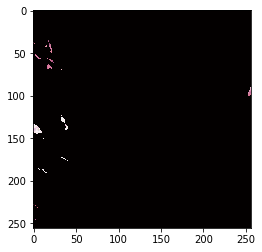

In [25]:
# Step2: Draw largest object circles for each identified pixels - Inside Circle White
white_pixels_ic_len = len(white_cir_inside)

white_xc_ic_1 = [] # Inside Circle Coordinates
white_yc_ic_1 = [] # Inside Circle Coordinates
white_radius_ic = [] # Inside circle Radius

for i in range(0, white_pixels_ic_len-1):
    cv2.circle(imInput,(white_cir_inside[i][0],white_cir_inside[i][1]),1, 3)    
    cv2.imwrite('/home/raj/Downloads/white_obj_ic_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
                cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))

im = cv2.imread('/home/raj/Downloads/white_obj_ic_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show() 

In [26]:
# Step2: Draw largest object circles for each identified pixels - On Circle
white_pixels_oc_len = len(white_cir_oncircle)
white_xc_oc_1 = [] # On Circle Coordinates
white_yc_oc_1 = [] # On Circle Coordinates
white_radius_oc = [] # On circle Radius

for i in range(0, white_pixels_oc_len-1):
    cv2.circle(imInput,(white_cir_oncircle[i][0],white_cir_oncircle[i][1]),1, 3)    
    cv2.imwrite('/home/raj/Downloads/white_obj_oc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
                cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))

im = cv2.imread('/home/raj/Downloads/white_obj_oc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show() 

error: OpenCV(3.4.3) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


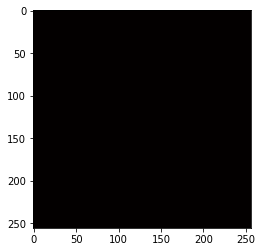

In [27]:
# Step2: Draw largest object circles for each identified pixels - Outside Circle
white_pixels_ouc_len = len(white_cir_outside)

white_xc_ouc_1 = [] # Outside Circle Coordinates
white_yc_ouc_1 = [] # Outside Circle Coordinates
white_radius_ouc = [] # Outside circle Radius

for i in range(0, white_pixels_ouc_len-1):
    cv2.circle(imInput,(white_cir_outside[i][0],white_cir_outside[i][1]),1, 3)    
    cv2.imwrite('/home/raj/Downloads/white_obj_ouc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
                cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))

im = cv2.imread('/home/raj/Downloads/white_obj_ouc_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show() 

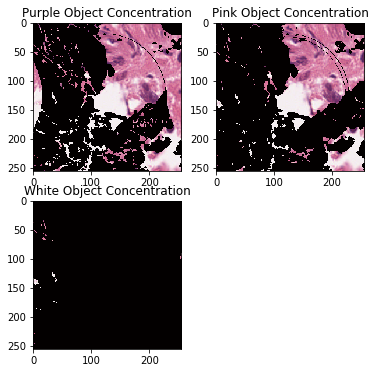

In [28]:
fig=plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title("Purple Object Concentration")
im1 = cv2.imread('/home/raj/Downloads/purple_obj_ic_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax2 = fig.add_subplot(2,2,2)
ax2.set_title("Pink Object Concentration")
im2 = cv2.imread('/home/raj/Downloads/pink_obj_ic_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax2.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

ax3 = fig.add_subplot(2,2,3)
ax3.set_title("White Object Concentration")
im3 = cv2.imread('/home/raj/Downloads/white_obj_ic_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax3.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))
plt.show()